In [137]:
import gpflow as gp
import tensorflow as tf
import tensorflow_probability as tfp
from bayes_tec.datapack import DataPack
import numpy as np
from bayes_tec.utils.data_utils import calculate_weights, make_coord_array

import warnings
warnings.filterwarnings("ignore")
import astropy.coordinates as ac
import astropy.time as at
import astropy.units as au

from scipy.linalg import solve_triangular

def optimal_sigma(C, y):
    #0.5 Tr(I)/var = 0.5 y^t I/var Kinv y
    #Tr(I) = y^t var Cinv y
    #var = <y,Cinv y>/Tr(I)
    v = np.std(y)
    C = C/np.mean(np.diag(C)) + 1e-3*np.eye(C.shape[0])
    L = np.linalg.cholesky(C)
    alpha = v*solve_triangular(L,y/v,lower=True)
    print(np.sum(alpha*alpha,axis=0))
    return np.sqrt(np.sum(alpha*alpha,axis=0))

def dialated_faceted(ra_cen_rad, dec_cen_rad, f_min=0.25, f_max=0.5, fov=2.5, N=20):
    l = np.linspace(-fov/2.,fov/2,N)
    dl = l[1] - l[0]
    #f_max = dl * (a + b * |fov|/2)
    #f_min = dl * (a)
    a = f_min / dl
    b = (f_max / dl - a)* 2. / fov
    
    dirs = np.meshgrid(l, l,indexing='ij')
    R = np.sqrt(dirs[0]**2 + dirs[1]**2)
    dialate = a + b * R
    dirs[0] *= dialate
    dirs[1] *= dialate
    
    dirs = np.stack([ra_cen_rad + np.pi / 180. * dirs[0].flatten(), 
                     dec_cen_rad + np.pi / 180. * dirs[1].flatten()], axis=1)
    
    return dirs

def make_solsets(datapack,output_solset, screen_res=20, extend = 0., solset='sol000'):
    screen_solset = "screen_{}".format(output_solset)
    
    datapack.switch_solset(solset)
    datapack.select(ant=None,time=None, dir=None, freq=None, pol=slice(0,1,1))
    axes = datapack.__getattr__("axes_{}".format('phase'))

    antenna_labels, antennas = datapack.get_antennas(axes['ant'])
    patch_names, directions = datapack.get_sources(axes['dir'])
    timestamps, times = datapack.get_times(axes['time'])
    freq_labels, freqs = datapack.get_freqs(axes['freq'])
    pol_labels, pols = datapack.get_pols(axes['pol'])

    Npol, Nd, Na, Nf, Nt = len(pols), len(directions), len(antennas), len(freqs), len(times)
    
    screen_directions = dialated_faceted(directions.ra.rad.mean(), directions.dec.rad.mean(),
                                        N=screen_res)

#     screen_ra = np.linspace(np.min(directions.ra.rad) - extend*np.pi/180., 
#             np.max(directions.ra.rad) + extend*np.pi/180., screen_res)
#     screen_dec = np.linspace(max(-90.*np.pi/180.,np.min(directions.dec.rad) - extend*np.pi/180.), 
#             min(90.*np.pi/180.,np.max(directions.dec.rad) + extend*np.pi/180.), screen_res)
#     screen_directions = np.stack([m.flatten() \
#             for m in np.meshgrid(screen_ra, screen_dec, indexing='ij')], axis=1)
    screen_directions = ac.SkyCoord(screen_directions[:,0]*au.rad,screen_directions[:,1]*au.rad,frame='icrs')
    Nd_screen = screen_res**2

    datapack.switch_solset(output_solset, 
            array_file=DataPack.lofar_array, 
            directions = np.stack([directions.ra.rad,directions.dec.rad],axis=1), patch_names=patch_names)
    datapack.add_freq_indep_tab('tec', times.mjd*86400., pols = pol_labels)   
    datapack.add_freq_dep_tab('amplitude', times.mjd*86400., pols = pol_labels,freqs=freqs)
    datapack.add_freq_dep_tab('phase', times.mjd*86400., pols = pol_labels,freqs=freqs)


    datapack.switch_solset(screen_solset, 
            array_file = DataPack.lofar_array, 
            directions = np.stack([screen_directions.ra.rad,screen_directions.dec.rad],axis=1))
    datapack.add_freq_indep_tab('tec', times.mjd*86400., pols = pol_labels)
    datapack.add_freq_dep_tab('amplitude', times.mjd*86400., pols = pol_labels,freqs=freqs)
    datapack.add_freq_dep_tab('phase', times.mjd*86400., pols = pol_labels,freqs=freqs)

    datapack.switch_solset(solset)


def gain_solve(datapack, solset='sol000', posterior_solset='posterior_sol', ant_sel=None, time_sel=None,dir_sel=None, pol_sel=slice(0,1,1), freq_sel=slice(0,48,1),
                  flag_dirs=[3,9,10,11,12,16,17,27,31],gp_vars = None, do_solve=False):
    with DataPack(datapack,readonly=True) as datapack:
        datapack.switch_solset(solset)
        datapack.select(time=time_sel, ant=ant_sel,pol=pol_sel, dir=dir_sel,freq=freq_sel)
        phase, axes = datapack.phase
        amp, axes = datapack.amplitude
        patch_names, directions = datapack.get_sources(axes['dir'])
        antenna_labels, antennas = datapack.get_antennas(axes['ant'])
        timestamps, times = datapack.get_times(axes['time'])
        _,freqs = datapack.get_freqs(axes['freq'])
        select = np.where(~np.isin(np.arange(len(patch_names)), np.array(flag_dirs)))[0]

    gains = amp*np.exp(1j*phase)
    gains = gains[0,select,:,:]
    var = calculate_weights(gains.real,indep_axis=-1, N=4,phase_wrap=False) + calculate_weights(gains.imag,indep_axis=-1, N=4,phase_wrap=False)
    var = var.mean(-2)
    var[...,:2] = var[...,3:4]
    var[...,-2:] = var[..., -3:-2]
    var = np.median(np.median(var, axis=1))

        
    X_t = (times.mjd*86000. - times[0].mjd*86400.)
    X_t = X_t[:,None]
    X_d = np.array([directions.ra.deg - directions.ra.deg.mean(), 
                  directions.dec.deg - directions.dec.deg.mean()]).T.astype(np.float64)
    X = make_coord_array(X_t, X_d[select,:],flat=True)
    with datapack:
        datapack.switch_solset(posterior_solset)
        datapack.select(time=time_sel, ant=ant_sel,pol=pol_sel, dir=dir_sel,freq=freq_sel)
        axes = datapack.axes_tec
        patch_names, directions = datapack.get_sources(axes['dir'])
        antenna_labels, antennas = datapack.get_antennas(axes['ant'])
        timestamps, times = datapack.get_times(axes['time'])
    
    X_t = (times.mjd*86000. - times[0].mjd*86400.)
    X_t = X_t[:,None]
    X_d = np.array([directions.ra.deg - directions.ra.deg.mean(), 
                  directions.dec.deg - directions.dec.deg.mean()]).T.astype(np.float64)
    Xstar = make_coord_array(X_t, X_d,flat=True)
        
    Npol,Nd,Na,Nf,Nt = phase.shape
    Nd_ = len(select)
    #Nt*Nd, Na*Nf
    Y = gains.transpose((3,0,1,2)).reshape((Nt*Nd_,-1))
    Y = np.concatenate([Y.real,Y.imag],axis=1)
    y_mean = Y.mean(0,keepdims=True)
    Y -= y_mean
#     y_std = Y.std(0,keepdims=True)+1e-8
# #     print(y_std)
#     Y /= y_std

#     var /= np.mean(y_std**2)
    
    with tf.Session(graph=tf.Graph()) as sess:
        with gp.defer_build():
            kernt = gp.kernels.RBF(1,active_dims=slice(0,1,1))
            kernd = gp.kernels.RBF(2,active_dims=slice(1,3,1))
            kernt.lengthscales = 80.
            kernt.lengthscales.transform = gp.transforms.positiveRescale(80.)
            kernd.lengthscales = 1.4
            kernd.lengthscales.trainable = False
            kernt.variance = 1.
            kernt.variance.transform = gp.transforms.positiveRescale(0.75)
            kernd.variance.trainable = False
            kern = kernt*kernd
            kern.compile()
            K = kern.compute_K_symm(X)
            #2*Na*Nf
#             print(Y)
            sigma = optimal_sigma(K,Y)
            print(sigma)
            Y /= sigma
            m = gp.models.GPR(X.astype(np.float64),Y.astype(np.float64),kern)
            m.likelihood.variance = var/np.mean(sigma**2)
            m.likelihood.variance.trainable = False
            m.compile()
        if gp_vars is not None:
            m.assign(gp_vars)
            
        if do_solve:
            gp.train.ScipyOptimizer().minimize(m)
            print(m)
        ystar,varstar = m.predict_y(Xstar.astype(np.float64))
    ystar = (ystar * sigma + y_mean)
    real = ystar[:,:Na*Nf].reshape((Nt,Nd,Na,Nf)).transpose((1,2,3,0))
    imag = ystar[:,Na*Nf:].reshape((Nt,Nd,Na,Nf)).transpose((1,2,3,0))
    gstar = real + 1j*imag
    varstar = varstar * sigma**2
    real = varstar[:, :Na*Nf].reshape((Nt,Nd,Na,Nf)).transpose((1,2,3,0))
    imag = varstar[:, Na*Nf:].reshape((Nt,Nd,Na,Nf)).transpose((1,2,3,0))
    gvarstar = real + 1j*imag
    
    return gstar, gvarstar, m.read_trainables()

def get_freq_weights(gains, freqs):
    tec_conv = -8.448e9/freqs
    
    with tf.Session(graph=tf.Graph()) as sess:
        phi_pl = tf.placeholder(tf.float64,shape=gains.shape)
        phi_ = tf.Variable(phi_pl)
        tec_conv_pl = tf.placeholder(tf.float64, shape=freqs.shape)
        tec_conv_ = tf.Variable(tec_conv_pl)
        log_w = tf.Variable(np.zeros(len(freqs)),dtype=tf.float64)
        w = tf.exp(log_w)
        w /= tf.reduce_sum(w)

        dtec = phi_ / tec_conv_[:,None]
        dtec_mu = tf.reduce_sum(dtec*w[:,None],axis=-2)

        dtec_var = tf.reduce_sum(dtec**2*w[:,None],axis=-2) - dtec_mu**2

        loss = tf.reduce_mean(dtec_var)# + tf.reduce_sum(tf.abs(w_))

        opt = tf.train.AdamOptimizer(1e-3).minimize(loss,var_list=[log_w])

        init = tf.global_variables_initializer()
        sess.run(init,feed_dict={phi_pl:np.angle(gains), tec_conv_pl:tec_conv})

        for i in range(1000):
            _, loss_, w_ = sess.run([opt, loss, w])
#             print(i, loss_)
        return w_
            
            

In [138]:
import seaborn as sns
import pylab as plt
import pandas as pd
from bayes_tec.utils.data_utils import define_equal_subsets
import os
from timeit import default_timer

max_block_size, min_overlap = 75, 0

with DataPack('../../scripts/data/killms_datapack_4.hdf5',readonly=False) as datapack:
    datapack.select(time=None, ant=None)
    axes = datapack.axes_phase
    patch_names, directions = datapack.get_sources(axes['dir'])
    antenna_labels, antennas = datapack.get_antennas(axes['ant'])
    timestamps, times = datapack.get_times(axes['time'])
    _,freqs = datapack.get_freqs(axes['freq'])
    pol_labels,pols = datapack.get_pols(axes['pol'])
    
with datapack:
    datapack.switch_solset('sol000')
    datapack.select(ant=slice(1,2,1),time=None,dir=None,pol=slice(0,1,1), freq=slice(0,48,1))
    phase,_ = datapack.phase
    amp,_ = datapack.amplitude
gains = amp * np.exp(1j*phase)

with datapack:
    make_solsets(datapack,'posterior_sol', screen_res=20, extend = 0., solset='sol000')
    
# datapack.switch_solset('posterior_sol_2', 
#             array_file=DataPack.lofar_array, 
#             directions = np.stack([directions.ra.rad,directions.dec.rad],axis=1), patch_names=patch_names)
# datapack.add_freq_dep_tab('phase', times.mjd*86400., pols = pol_labels,freqs=freqs)
# datapack.add_freq_dep_tab('amplitude', times.mjd*86400., pols = pol_labels,freqs=freqs)
    
Nt = len(times)
solve_slices, _, _ = define_equal_subsets(Nt,max_block_size, min_overlap)

t0 = default_timer()
gp_vars = None
for i in range(1,62,1):
    ant = antenna_labels[i]
    print(ant)
    for j, solve_slice in enumerate(solve_slices):
        time_slice = slice(*solve_slice, 1)
        gstar, gvarstar, gp_vars = gain_solve('../../scripts/data/killms_datapack_4.hdf5', solset='sol000',
                                              posterior_solset='screen_posterior_sol',
                                   ant_sel=slice(i,i+1,1), time_sel=time_slice, dir_sel=None, 
                                   pol_sel=slice(0,1,1), freq_sel=slice(0,48,1),
                               flag_dirs=[3,27,36,9,0,16,12,24,17,11,31,20,38,35,21,34,10,1], 
                                gp_vars=gp_vars, do_solve= False )
        #,[1,3,9,10,11,12,16,17,27,31,34,36]
        with datapack:
            datapack.switch_solset('screen_posterior_sol')
            datapack.select(ant=slice(i,i+1,1),time=time_slice,dir=None,pol=slice(0,1,1), freq=slice(0,48,1))
            datapack.phase = np.angle(gstar[None,...])
            datapack.amplitude = np.abs(gstar[None,...])
        t1 = default_timer()
        num_left = len(solve_slices)*61 - j - (i-1)*len(solve_slices) - 1
        rate = (t1-t0)/(1 + j + (i-1) * len(solve_slices))
        print("Time left: {} s".format(num_left*rate))
        

ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


MemoryError: 

In [9]:
with DataPack('../../scripts/data/killms_datapack_4.hdf5',readonly=True) as datapack:
    datapack.select(time=None, ant='RS210HBA')
    phase,_ = datapack.phase
    amp,_ = datapack.amplitude
    
    axes = datapack.axes_phase
    patch_names, directions = datapack.get_sources(axes['dir'])
    antenna_labels, antennas = datapack.get_antennas(axes['ant'])
    timestamps, times = datapack.get_times(axes['time'])
    _,freqs = datapack.get_freqs(axes['freq'])
    pol_labels,pols = datapack.get_pols(axes['pol'])

gains = amp * np.exp(1j*phase)


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


In [14]:
X_d = np.array([directions.ra.deg - directions.ra.deg.mean(), 
                  directions.dec.deg - directions.dec.deg.mean()]).T.astype(np.float64)
from scipy.spatial.distance import cdist
d = cdist(X_d,X_d)
a = np.argsort(d,axis=-1)

In [208]:
np.diag(np.linalg.cholesky(C))

array([1.00000005, 0.13970514, 0.11576099, 0.14624412, 0.04759838,
       0.0184814 , 0.20245043, 0.21368737, 0.11351445, 0.10454001,
       0.12604113, 0.1562793 , 0.10480569, 0.10355705, 0.17772359,
       0.03839706, 0.02750068, 0.0850449 , 0.07077835, 0.08896197,
       0.20844098, 0.08727542, 0.12823766, 0.04682922, 0.1075388 ,
       0.15371787, 0.1424399 , 0.07240999, 0.13960583, 0.04266368,
       0.18765292, 0.14117413, 0.1929822 , 0.19051018, 0.30964957,
       0.1749253 , 0.18037347, 0.103482  , 0.19358929, 0.08122665,
       0.2094894 , 0.07670194, 0.03103769, 0.19555166, 0.16204982,
       0.16939279, 0.09180371, 0.14739573, 0.05090775, 0.1637864 ,
       0.14430344, 0.07519323, 0.13552027, 0.32060869, 0.1362296 ,
       0.13169599, 0.22886152, 0.22172146, 0.364444  , 0.13688462,
       0.16817952, 0.13158899, 0.05571126, 0.11005981, 0.01641819,
       0.20513412, 0.02462038, 0.16865749, 0.04720391, 0.12128521,
       0.0860187 , 0.12953102, 0.09249132, 0.11297948, 0.13228

In [62]:
#2, Nd
nearest_dist = np.diagonal(d[:,a[:,1:4]],axis1=0,axis2=1)
print(nearest_dist)
s = np.var(np.diff(np.unwrap(phase)),axis=-1).mean(-1)

[[1.07459638 1.56478398 1.05043603 0.61953826 0.85280895 0.12576768
  0.72086407 0.5455718  1.08302037 1.37936325 1.84813827 0.7825372
  0.36583898 0.97257506 1.29080563 0.83634688 0.36583898 1.1760292
  1.37936325 1.15519421 0.12576768 1.22787317 0.78049812 0.97257506
  0.60517743 1.10635811 0.69891519 0.61953826 0.52566201 1.08427531
  0.83634688 0.7825372  0.9817734  0.5455718  1.63759768 1.52867303
  1.38741951 0.60517743 0.73597101 0.52566201 0.72086407 1.0803982
  0.69891519 1.63759768 1.08427531]
 [1.34011152 1.61819378 1.08302037 1.92218988 1.16548497 0.76960759
  1.25948512 0.98406071 1.42552008 2.49733305 2.26526908 1.1760292
  1.04538173 1.50464592 1.50464592 0.9817734  1.07459638 1.57452251
  1.42378861 1.21258928 0.73597101 2.03520416 1.05043603 1.42378861
  1.04538173 1.22143066 0.78049812 1.38741951 0.82596676 1.11093788
  1.22787317 1.41879334 1.10635811 0.82596676 1.84813827 2.25267776
  1.71152478 0.86264371 0.76960759 0.8704557  0.86264371 1.29757899
  1.11093788 1.6

(1000, 2)


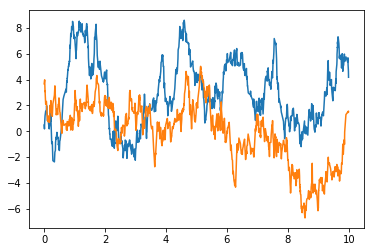

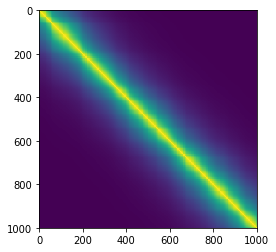

[9.75320086 9.85556039]


In [176]:
from scipy.linalg import cho_solve

def optimal_variance(C, y):
    #0.5 Tr(I)/var = 0.5 y^t I/var Kinv y
    #Tr(I) = y^t var Cinv y
    #var = <y,Cinv y>/Tr(I)
    C = C/np.mean(np.diag(C))
    alpha = np.linalg.solve(C,y)
    return np.sum(y*alpha,axis=0)/C.shape[0]

kern = gp.kernels.Matern12(1,variance = 1.)
X = np.sort(np.random.uniform(size=(1000,1))*10,axis=0)
K = 10*kern.compute_K_symm(X) + 1e-6*np.eye(1000)
L = np.linalg.cholesky(K)
y = L.dot(np.random.normal(size=(1000,2)))
print(y.shape)
plt.plot(X[:,0],y)
plt.show()

kern_ = gp.kernels.Matern52(1,variance=1.)
C = kern.compute_K_symm(X) + 1e-7*np.eye(1000)
plt.imshow(K - C)
plt.show()
var = optimal_variance(C,y)
print(var)

In [223]:
with datapack:
    datapack.switch_solset('posterior_sol')
    datapack.select(ant=None,time=None,dir=None,pol=slice(0,1,1), freq=slice(0,48,1))
    phase,_ = datapack.phase
    amp,_ = datapack.amplitude
    
    
datapack.add_freq_indep_tab('tec', times.mjd*86400., pols = pol_labels)

    
gains = amp * np.exp(1j*phase)
# w_array = []
# Npol, Nd, Na, Nf, Nt = phase.shape
# t0 = default_timer()
# tec = np.zeros((Npol, Nd, Na, Nt))
# for i in range(1,62,1):
#     print(antenna_labels[i])
#     w = get_freq_weights(gains[:,:,i,:,:], freqs[:48])
#     w_array.append(w)
#     tec_conv = -8.448e9/freqs[:48]
#     tec[:,:,i,:] = np.sum(phase[:,:,i,:,:] /tec_conv[:,None] * w[:,None],axis=-2)
#     t1 = default_timer()
#     num_left = 61 - i
#     rate = (t1-t0)/(i)
#     print("Time left: {} s".format(num_left*rate))
    
# with datapack:
#     datapack.switch_solset('posterior_sol')
#     datapack.tec = tec

ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


In [3]:
with DataPack('../../scripts/data/killms_datapack_4.hdf5',readonly=True) as datapack:
    datapack.switch_solset('posterior_sol')
    tec, axes = datapack.tec
    timestamps,times = datapack.get_times(axes['time'])

In [ ]:
import pylab as plt
plt.plot(times.mjd, tec[0,[10,34],51,:].T)
plt.show()

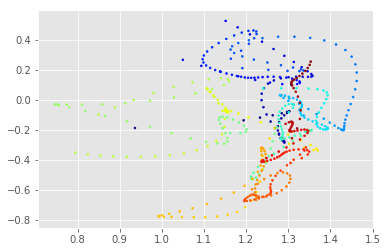

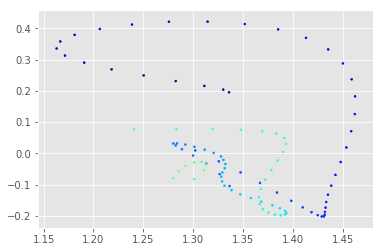

In [226]:
%matplotlib inline

plt.style.use('ggplot')
plt.scatter(gains[0,39,51,39,:500].real, gains[0,39,51,39,:500].imag, s=4, c=plt.cm.jet(np.arange(500.)/500.))
plt.show()
plt.scatter(gains[0,39,51,39,100:200].real, gains[0,39,51,39,100:200].imag, s=4, c=plt.cm.jet(np.arange(100.)/200.))
plt.show()

In [ ]:
phi_ = np.angle(gains)
tec_conv = -8.448e9/freqs[:48]
tec = np.sum(phi_ /tec_conv[:,None] * w[:,None],axis=-2)
phi = tec[...,None,:]*tec_conv[:,None]
plt.plot(np.abs(phi[0,39,0,30,1:] - phi[0,39,0,30,:-1]))
plt.show()
plt.figure(figsize=(12,12))

plt.plot(np.abs(phi_[0,39,0,30,1:] - phi_[0,39,0,30,:-1]))
plt.show()
plt.figure(figsize=(12,12))

plt.plot(phi_[0,39,0,::10,:500].T)
plt.show()
plt.plot(tec[0,39,0,:500].T)
plt.show()
plt.plot(phi[0,39,0,::10,:500].T)
plt.show()

gains_ = amp * np.exp(1j*phi)
plt.scatter(gains_[0,39,0,30,:500].real, gains_[0,39,0,30,:500].imag, s=4, c=plt.cm.jet(np.arange(500.)/500.))
plt.show()
plt.scatter(gains_[0,39,0,30,100:200].real, gains_[0,39,0,30,100:200].imag, s=4, c=plt.cm.jet(np.arange(100.)/200.))
plt.show()

plt.scatter(gains[0,39,0,30,:500].real, gains[0,39,0,30,:500].imag, s=4, c=plt.cm.jet(np.arange(500.)/500.))
plt.show()
plt.scatter(gains[0,39,0,30,100:200].real, gains[0,39,0,30,100:200].imag, s=4, c=plt.cm.jet(np.arange(100.)/200.))
plt.show()

dgains = gains - gains_

plt.scatter(dgains[0,39,0,30,:500].real, dgains[0,39,0,30,:500].imag, s=4, c=plt.cm.jet(np.arange(500.)/500.))
plt.show()
plt.scatter(dgains[0,39,0,30,100:200].real, dgains[0,39,0,30,100:200].imag, s=4, c=plt.cm.jet(np.arange(100.)/200.))
plt.show()

In [34]:
from bayes_tec.plotting.plot_datapack import animate_datapack, plot_solution_residuals, plot_data_vs_solution

In [ ]:
animate_datapack('../../scripts/data/killms_datapack_4.hdf5','figs_gain_solve_2',10,solset='posterior_sol',
                 observable='tec', tec_eval_freq=140e6, phase_wrap=True, plot_facet_idx=True, labels_in_radec=True)

In [11]:
plot_solution_residuals('../../scripts/data/killms_datapack_4.hdf5','figs_sol',solution_solset='posterior_sol',ant_sel='RS*',pol_sel=slice(0,1,1))

In [35]:
plot_data_vs_solution('../../scripts/data/killms_datapack_4.hdf5','figs_1d',ant_sel='RS*',pol_sel=slice(0,1,1),freq_sel=slice(0,None,10))

In [239]:
H = tables.open_file('../../scripts/data/killms_datapack_4.hdf5')
raNode, decNode = H.root.posterior_sol.source[:]['dir'].T
times = H.root.posterior_sol.tec000.time[:]
tec = H.root.posterior_sol.tec000.val[:]
H.close()
del(H)

In [126]:
def dialated_faceted(f_min=0.25, f_max=0.5, fov=2.5, N=20):
    l = np.linspace(-fov/2.,fov/2,N)
    dl = l[1] - l[0]
    #f_max = dl * (a + b * |fov|/2)
    #f_min = dl * (a)
    a = f_min / dl
    b = (f_max / dl - a)* 2. / fov
    
    dirs = np.meshgrid(l, l,indexing='ij')
    R = np.sqrt(dirs[0]**2 + dirs[1]**2)
    dialate = a + b * R
    dirs[0] *= dialate
    dirs[1] *= dialate
    
    dirs = np.stack([dirs[0].flatten(), dirs[1].flatten()], axis=1)
    
    return dirs

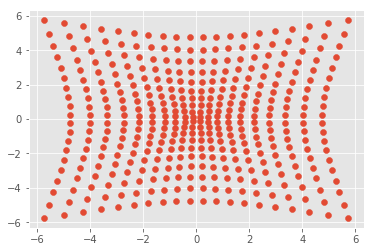

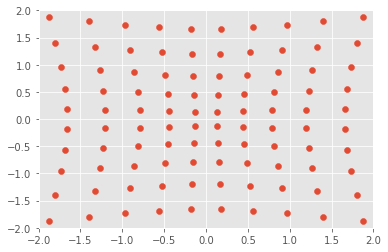

In [127]:
import pylab as plt
%matplotlib inline
dirs = dialated_faceted()
plt.scatter(dirs[:,0],dirs[:,1])
# plt.xlim(-2,2)
# plt.ylim(-2,2)
plt.show()
plt.scatter(dirs[:,0],dirs[:,1])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

In [238]:
import astropy.time as at
at.Time(times/86400.,format='mjd').isot

array(['2016-12-08T23:12:13.006', '2016-12-08T23:20:41.006',
       '2016-12-08T23:20:49.006', ..., '2016-12-09T07:20:08.934',
       '2016-12-09T07:20:16.934', '2016-12-09T07:28:44.934'], dtype='<U23')

In [33]:
"af".split('+')

['af']

In [31]:
with DataPack('../../scripts/data/killms_datapack_4.hdf5',readonly=True) as datapack:
    datapack.split_solset('sol000','A665_original_sols.h5',new_solset='sol000',soltabs=['phase','amplitude'],clobber=True)

MemoryError: 

In [8]:
times.isot[:2], times.isot[-2:]


(array(['2016-12-08T23:12:13.006', '2016-12-08T23:20:41.006'], dtype='<U23'),
 array(['2016-12-09T07:20:16.934', '2016-12-09T07:28:44.934'], dtype='<U23'))